# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [38]:
# Load pickled data
import pickle

home_folder = '/home/hkorre/Documents/proj2/'   #Linux VM
#home_folder = '/home/'                          #Docker Image

# TODO: fill this in based on where you saved the training and testing data
training_file = home_folder + 'traffic-signs/lab2_data/train.p'
testing_file  = home_folder + 'traffic-signs/lab2_data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

print('Success: Data loaded.')

Success: Data loaded.


In [39]:
### To start off let's do a basic data summary.

# TODO: number of training examples
n_train = X_train.shape[0]

# TODO: number of testing examples
n_test = X_test.shape[0]

# TODO: what's the shape of an image?
image_shape = (X_train.shape[1], X_train.shape[2])

# TODO: how many classes are in the dataset
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43


This image is: <class 'numpy.ndarray'> with dimesions: (32, 32, 3)
Showing image # 20000 ...


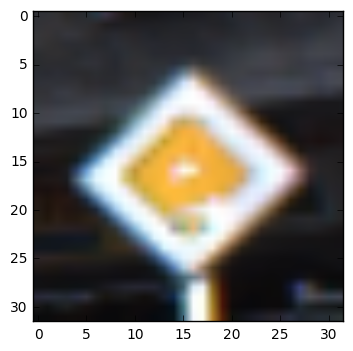

In [40]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
#from PIL import Image

%matplotlib inline

# grab an image
image_num = 20000
image = X_train[image_num,:,:,:]

# Show image
print('This image is:', type(image), 'with dimesions:', image.shape)
print('Showing image #', image_num, '...')
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

In [41]:
import numpy as np
from sklearn.preprocessing import LabelBinarizer



### Grayscale the images #########################################
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def grayscale_features(dataset_, num_samples_, image_shape_):
    gray = np.empty([num_samples_, image_shape_[0], image_shape_[1]], dtype=dataset_.dtype)
    for index in range(0, num_samples_):
        gray[index,:,:] = grayscale(dataset_[index,:,:,:])
    
    return gray


### Data Flattening ##############################################
def flatten_features(gray_, num_samples_, image_shape_):
    flat = np.empty([num_samples_, image_shape_[0]*image_shape_[1]], dtype=gray_.dtype)
    for index in range(0, num_samples_):
        flat[index,:] = gray_[index,:,:].flatten()
        
    return flat


### Data Normalization ###########################################
def normalize_features(img_):
    #change type to np.float32 to accomodate negative numbers
    #  and get ready for further math
    normalized = (img_.astype(np.float32) - 128)/128    
    return normalized

def normalize_features_pos(img_):
    """
    Normalize the image data with Min-Max scaling to a range of [0.1, 0.9]
    :param image_data: The image data to be normalized
    :return: Normalized image data
    """
    out_min = 0.1
    out_max = 0.9
    greyscale_min = 0
    greyscale_max = 255
    
    slope = (out_max - out_min)/( greyscale_max - greyscale_min )
    b = out_min
    return slope*(img_.astype(np.float32) - greyscale_min) + out_min


### One Hot Encode the labels ######################################

# Turn labels into numbers and apply One-Hot Encoding
# i.e. each solution is turned into a unit row vector
def oneHotEncode_labels(labels_):
    encoder = LabelBinarizer()
    one_hot_encoded = encoder.fit_transform(labels_)

    return one_hot_encoded


print('Success: Preprocessing functions loaded.')

Success: Preprocessing functions loaded.


In [42]:
# Preprocess Data
X_train_gray = grayscale_features(X_train, n_train, image_shape)
X_train_norm = normalize_features_pos(X_train_gray)
y_train_OHE = oneHotEncode_labels(y_train)

X_test_gray = grayscale_features(X_test, n_test, image_shape)
X_test_norm = normalize_features_pos(X_test_gray)
y_test_OHE = oneHotEncode_labels(y_test)

print('Success: Data preprocessed.')

Success: Data preprocessed.


### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**

For the data:
* Switch to grayscale
* Normalize the data between 0.1-0.9

For the labels:
* One-hot-encode the labels

In [ ]:
### Generate data additional (if you want to!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

In [43]:
from sklearn.model_selection import train_test_split
from random import randint

### Split into train and validation sets ###########################
def split_training(x_train_, y_train_):
    (train_features, valid_features, train_labels, valid_labels) = \
      train_test_split(x_train_, y_train_, test_size=0.05, random_state=832289, stratify=y_train_)
        
    return (train_features, valid_features, train_labels, valid_labels)

def split_training_rand(x_train_, y_train_):
    rand_min = 0
    rand_max = 832289
    
    (train_features, valid_features, train_labels, valid_labels) = \
      train_test_split(x_train_, y_train_, test_size=0.05, random_state=randint(rand_min,rand_max), stratify=y_train_)
        
    return (train_features, valid_features, train_labels, valid_labels)


print('Success: Data split functions loaded.')

Success: Data split functions loaded.


In [44]:
(train_features, valid_features, train_labels, valid_labels) = \
  split_training_rand(X_train_norm, y_train_OHE)

test_features = X_test_norm
test_labels = y_test_OHE

print('Success: Data sets generated.')

Success: Data sets generated.


### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**

I split the training set into training and validation. I also do the following:
* Small validation set (~5%)
* Try to feed random number to the generator to get different data every time I test
* Stratify the data to make sure to get the same proportions in validation data as in training data

In [ ]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

In [45]:
# Convolutional Neural Network
# Based on https://github.com/aymericdamien/TensorFlow-Examples - convolutional_network
# and "Traffice Sign Recognition with Multi-Scale Convolutional Networks" by Sermanet & LeCun

import tensorflow as tf
import matplotlib.pyplot as plt



# Parameters
learning_rate = 0.01

n_hidden_1 = 128    # 1st layer number of features
n_hidden_2 = 128    # 2nd layer number of features

# Network Parameters
n_input = image_shape[0]*image_shape[1]  # data input (img shape: 32*32)
n_classes = n_classes                    # total classes (0-42 digits = 43)
dropout = 0.75                           # Dropout, probability to keep units

init_stdev = 0.05


# Sizing parameters
pool_sizeNstride   = 2               #pooling size & stride

input_channels     = 1               #grayscale
input_size         = image_shape[0]  #size of 1 side of input square

wc1_convoSize      = 5               #size of 1 side of convo sq  
wc1_outDepth       = 16              #convo output depth
wc1_outSize        = int(input_size/pool_sizeNstride)  #size of 1 size of output sq

wc2_convoSize      = 5
wc2_outDepth       = 32
wc2_outSize        = int(wc1_outSize/pool_sizeNstride)

wc1_total          = wc1_outSize*wc1_outSize*wc1_outDepth
wc2_total          = wc2_outSize*wc2_outSize*wc2_outDepth
multiscale_len     = wc1_total + wc2_total      #mutli-scale feature results


# tf Graph input
x = tf.placeholder(tf.float32, [None, image_shape[0], image_shape[1]])
y = tf.placeholder(tf.float32, [None, n_classes])
keep_prob = tf.placeholder(tf.float32)             #dropout (keep probability)


# Down-sampling
def maxpool2d(x_, k_=2):
    # MaxPool2D wrapper
    return tf.nn.max_pool(x_, ksize=[1, k_, k_, 1], strides=[1, k_, k_, 1],
                          padding='SAME')

    # x shape = shape [batch, height, width, channels]
    # ksize   = window in each dimension
    # strides = stride in each dimension


# Create some wrappers for simplicity
def conv2d(x_, W_, b_, drop_, strides_=1):
    x = tf.nn.conv2d(x_, W_, strides=[1, strides_, strides_, 1], padding='SAME')
    # x/input shape  = [batch, in_height, in_width, in_channels]
    # w/filter shape = [filter_height, filter_width, in_channels, out_channels]
    # stride shape   = [batch, in_height, in_width, in_channels]
    
    x = tf.nn.bias_add(x, b_)
    x = tf.nn.relu(x)
    x = tf.nn.dropout(x, drop_)
    x = maxpool2d(x, pool_sizeNstride)    
    return x


    
# Create model
def model(x_, weights_, biases_, dropout_):
    # Reshape input picture
    x = tf.reshape(x_, shape=[-1, image_shape[0], image_shape[1], 1])

    # Convolution Layer 1
    conv1 = conv2d(x, weights_['wc1'], biases_['bc1'], dropout_)
    
    # Convolution Layer 2
    conv2 = conv2d(conv1, weights_['wc2'], biases_['bc2'], dropout_)
    
    # Input to classifier
    flat1 = tf.reshape(conv1, [-1, wc1_total])  #row size should be batch size
    flat2 = tf.reshape(conv2, [-1, wc2_total])  #row size should be batch size
    classifier_input = tf.concat(1, [flat1, flat2])  #should concat the rows
    
    # Hidden layer with RELU activation
    h1 = tf.add(tf.matmul(classifier_input, weights['wh1']), biases['bh1'])      #WX+b
    h1 = tf.nn.relu(h1)
    h1 = tf.nn.dropout(h1, dropout_)
    
    # Hidden layer with RELU activation
    h2 = tf.add(tf.matmul(h1, weights['wh2']), biases['bh2'])     #WX+b
    h2 = tf.nn.relu(h2)
    h2 = tf.nn.dropout(h2, dropout_)
    
    # Output, 'classifier'
    out = tf.add(tf.matmul(h2, weights_['out']), biases_['out'])
    return out



# Store layers weight & bias

#w/filter shape = [filter_height, filter_width, in_channels, out_channels]
weights = {
    'wc1': tf.Variable(tf.random_normal([wc1_convoSize, wc1_convoSize, input_channels, wc1_outDepth], stddev=init_stdev)),
    'wc2': tf.Variable(tf.random_normal([wc2_convoSize, wc2_convoSize, wc1_outDepth, wc2_outDepth], stddev=init_stdev)),
    'wh1': tf.Variable(tf.random_normal([multiscale_len, n_hidden_1], stddev=init_stdev)),
    'wh2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2], stddev=init_stdev)),
    'out': tf.Variable(tf.random_normal([n_hidden_2, n_classes], stddev=init_stdev))
}

biases = {
    'bc1': tf.Variable(tf.random_normal([wc1_outDepth], stddev=init_stdev)),
    'bc2': tf.Variable(tf.random_normal([wc2_outDepth], stddev=init_stdev)),
    'bh1': tf.Variable(tf.random_normal([n_hidden_1], stddev=init_stdev)),
    'bh2': tf.Variable(tf.random_normal([n_hidden_2], stddev=init_stdev)),
    'out': tf.Variable(tf.random_normal([n_classes], stddev=init_stdev))
}


# Construct model
pred = model(x, weights, biases, keep_prob)

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(pred, y))


# L2 regularization for the fully connected parameters.
regularizers = tf.nn.l2_loss(weights['wc1']) + tf.nn.l2_loss(biases['bc1']) + \
               tf.nn.l2_loss(weights['wc2']) + tf.nn.l2_loss(biases['bc2']) + \
               tf.nn.l2_loss(weights['wh1']) + tf.nn.l2_loss(biases['bh1']) + \
               tf.nn.l2_loss(weights['wh2']) + tf.nn.l2_loss(biases['bh2']) + \
               tf.nn.l2_loss(weights['out']) + tf.nn.l2_loss(biases['out'])
# Add the regularization term to the loss.
beta = 5e-4  #0.0001
cost += beta * regularizers



print('Success: ConvNet defined.')

Success: ConvNet defined.


### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

My model looks like:
* ConvNet 1: 5x5 with 16 depth and 2x2 max pooling
* ConvNet 2: 5x5 with 32 depth and 2x2 max pooling
* Hidden Layer 1: 128 neurons
* Hidden Layer 2: 128 neurons
* Logit Layer

The ConvNet and Hidden Layers all have:
* relu
* dropout

I have L2 regularization on all weigths and biases.
I initialize the weights and biases with a small stddev (0.05) to make sure a weight doesn't accidentally dominate because of it's initial conditions.
The learning rate is 0.01, which is fast enough that the net can run in reasonable time.

In [ ]:
### Train your model here.
### Feel free to use as many code cells as needed.

Epoch: 0001 cost= 4.01568, Training Accuracy= 0.06935
Epoch: 0011 cost= 1.68769, Training Accuracy= 0.71035
Epoch: 0021 cost= 1.06807, Training Accuracy= 0.85569
Epoch: 0031 cost= 0.82934, Training Accuracy= 0.92198
Epoch: 0041 cost= 0.72493, Training Accuracy= 0.94850
Epoch: 0051 cost= 0.64842, Training Accuracy= 0.96634
Epoch: 0061 cost= 0.60541, Training Accuracy= 0.97603
Epoch: 0071 cost= 0.56500, Training Accuracy= 0.98113
Epoch: 0081 cost= 0.54135, Training Accuracy= 0.98572
Epoch: 0091 cost= 0.51813, Training Accuracy= 0.98725
Epoch: 0101 cost= 0.49226, Training Accuracy= 0.98776
Optimization Finished!
Accuracy: 0.898416
Model saved in file: model.ckpt


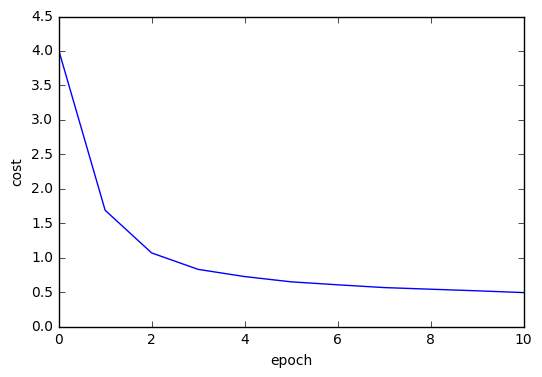

In [9]:
# Tune-ing variables
training_epochs = 101
batch_size = 100

# Display variables
display_step = 10
cost_batch = []     # plotting array

#optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Add ops to save and restore all the variables.
saver = tf.train.Saver()

# Initializing the variables
init = tf.initialize_all_variables()

# Launch the graph
with tf.Session() as sess:
    sess.run(init)

    # Training cycle
    for epoch in range(training_epochs):

        total_batch = int(train_features.shape[0]/batch_size)
        
        # Loop over all batches            
        for batch_i in range(total_batch):
            #batch_x, batch_y = mnist.train.next_batch(batch_size)
            batch_start = batch_i*batch_size
            batch_x = train_features[batch_start:batch_start + batch_size]
            batch_y = train_labels[batch_start:batch_start + batch_size]
            
            # Run optimization op (backprop) and cost op (to get loss value)
            sess.run(optimizer, feed_dict={x: batch_x, y: batch_y, keep_prob: dropout})         
        
        # Display logs per epoch step
        if epoch % display_step == 0:
            # run validation set
            c, acc = sess.run([cost, accuracy], feed_dict={x: valid_features, y: valid_labels, keep_prob: 1.})
            print("Epoch:", '%04d' % (epoch+1), "cost=", \
                "{:.5f}".format(c) + ", Training Accuracy= " + \
                  "{:.5f}".format(acc))
            cost_batch.append(c)
          
    print("Optimization Finished!")

    
    # Test model
    correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
    # Calculate accuracy - run test set
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    print("Accuracy:", accuracy.eval({x: test_features, y: test_labels, keep_prob: 1.}))

    # Save the variables to disk
    save_path = saver.save(sess, "model.ckpt")
    print("Model saved in file: %s" % save_path)
    
    # plot
    plt.plot(cost_batch)
    plt.ylabel('cost')
    plt.xlabel('epoch')
    plt.show()

    
### Results ########################################################
# Best test accuracy = 0.912431
# Training Accuracy  = 0.99388
# with learning_rate = 0.01 & training_epochs = 200

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

I use a Gradient Descent Optimizer. My batch size is 100 and I run 100 epochs.

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**

In order:
* I made a 2 layer perceptron model.
* Then I made a three layer perceptron model.
* Then I added the ConvNet.
* Then I added dropout
* Then I added L2 regularization

At each step, I optimized the parameters to get the best test accuracy

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

In [46]:
def img_import4(file_path_):
    image = mpimg.imread(file_path_)
    
    # make the image small in the middle
    image = cv2.resize(image, (22, 22), interpolation = cv2.INTER_AREA)
    
    # make a border around the edge 
    bordersize=5
    image=cv2.copyMakeBorder(image, top=bordersize, bottom=bordersize, \
                              left=bordersize, right=bordersize, \
                              borderType= cv2.BORDER_CONSTANT, \
                              value=[0,0,0] )
    return image


print('Success: new image helper functions defined.')

Success: new image helper functions defined.


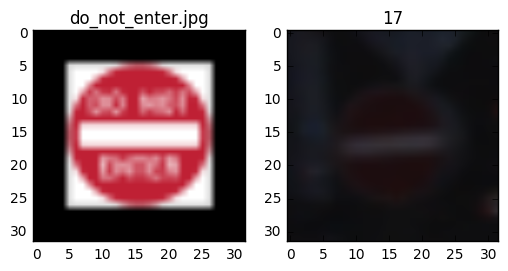

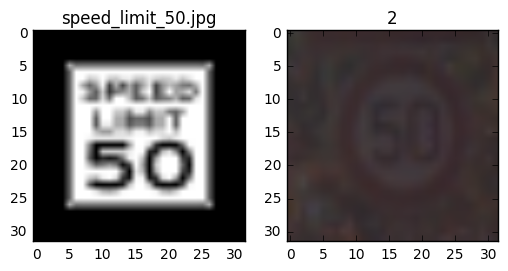

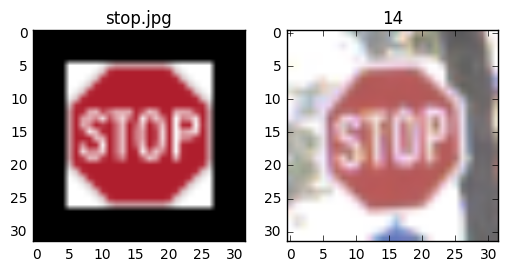

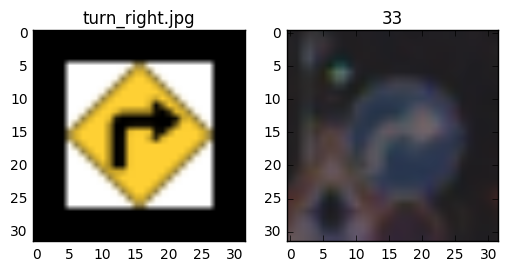

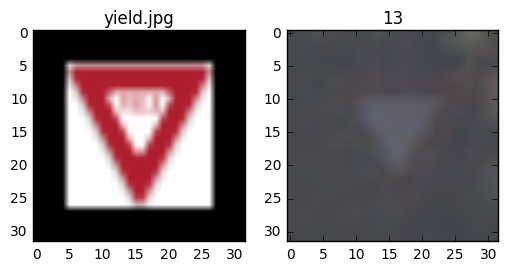

In [47]:
# Load and show images
# images from https://en.wikipedia.org/wiki/Road_signs_in_the_United_States

img_folder = home_folder + 'traffic-signs/new_images/'

img_names = []
img_names.append('do_not_enter.jpg')
img_names.append('speed_limit_50.jpg')
img_names.append('stop.jpg')
img_names.append('turn_right.jpg')
img_names.append('yield.jpg')

img_values = {}
img_values['do_not_enter.jpg']   = 17   #no entry
img_values['speed_limit_50.jpg'] = 2    #Speed limit (50km/h)
img_values['stop.jpg']           = 14   #Stop
img_values['turn_right.jpg']     = 33   #Turn right ahead
img_values['yield.jpg']          = 13   #Yield

extra_imgs = np.zeros([len(img_names),32,32,3], dtype=np.uint8)
extra_labels = []

for index, name in enumerate(img_names):
    extra_imgs[index] = img_import4(img_folder + name)
    fig = plt.figure()
    a=fig.add_subplot(1,2,1)
    a.set_title(name)
    plt.imshow(extra_imgs[index])
    
    # display an image from the training set that matches
    img_val = img_values[name]
    extra_labels.append(img_val)
    training_index = next(index for index, val in enumerate(y_train) if val==img_val)
    a=fig.add_subplot(1,2,2)
    a.set_title(str(img_val))
    plt.imshow(X_train[training_index])


### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

I looked at signnames.csv to see the classes that the ConvNet can recognize.
I tried to pick images that fall within classes that would be easy to recognize.

The following might be difficult to recognize:
* Speed Limit 50 - The shape is different but they both have the number 50 in them
* Turn Right - The shape is different, but they both have the arrow
* All - Is the background a factor? I had to make teh figure smaller to match the sizes in the training images, then I had to add a border to fill the rest of the shape

In [ ]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

In [53]:
extra_imgs_gray = grayscale_features(extra_imgs, 5, image_shape)
extra_imgs_norm = normalize_features_pos(extra_imgs_gray)
extra_labels_OHE = oneHotEncode_labels(extra_labels)

# Add ops to save and restore all the variables.
saver = tf.train.Saver()

pred_val = tf.argmax(pred, 1)

pred_softmax = tf.nn.softmax(pred)
pred_topFive = tf.nn.top_k(pred_softmax, k=5)

with tf.Session() as sess:
    
    # Restore variables from disk.
    saver.restore(sess, "model.ckpt")
    print("Model restored.")
    
    soln_vals, soln_topFive = sess.run([pred_val, pred_topFive], feed_dict={x: extra_imgs_norm, keep_prob: 1.})

    
print('soln_vals: ', soln_vals)

NotFoundError: Tensor name "Variable_10" not found in checkpoint files model.ckpt
	 [[Node: save_5/restore_slice_2 = RestoreSlice[dt=DT_FLOAT, preferred_shard=-1, _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_save_5/Const_0, save_5/restore_slice_2/tensor_name, save_5/restore_slice_2/shape_and_slice)]]

Caused by op 'save_5/restore_slice_2', defined at:
  File "/home/hkorre/anaconda3/envs/CarND-TensorFlow-Lab/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/hkorre/anaconda3/envs/CarND-TensorFlow-Lab/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/hkorre/anaconda3/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/hkorre/anaconda3/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/hkorre/anaconda3/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/hkorre/anaconda3/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/hkorre/anaconda3/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/hkorre/anaconda3/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/hkorre/anaconda3/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/hkorre/anaconda3/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/hkorre/anaconda3/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/hkorre/anaconda3/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/hkorre/anaconda3/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/hkorre/anaconda3/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/hkorre/anaconda3/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/home/hkorre/anaconda3/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/hkorre/anaconda3/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/hkorre/anaconda3/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/hkorre/anaconda3/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/hkorre/anaconda3/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-53-d5e99e7638b6>", line 6, in <module>
    saver = tf.train.Saver()
  File "/home/hkorre/anaconda3/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 986, in __init__
    self.build()
  File "/home/hkorre/anaconda3/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 1015, in build
    restore_sequentially=self._restore_sequentially)
  File "/home/hkorre/anaconda3/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 620, in build
    restore_sequentially, reshape)
  File "/home/hkorre/anaconda3/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 357, in _AddRestoreOps
    tensors = self.restore_op(filename_tensor, saveable, preferred_shard)
  File "/home/hkorre/anaconda3/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 270, in restore_op
    preferred_shard=preferred_shard))
  File "/home/hkorre/anaconda3/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/tensorflow/python/ops/io_ops.py", line 204, in _restore_slice
    preferred_shard, name=name)
  File "/home/hkorre/anaconda3/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/tensorflow/python/ops/gen_io_ops.py", line 359, in _restore_slice
    preferred_shard=preferred_shard, name=name)
  File "/home/hkorre/anaconda3/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 749, in apply_op
    op_def=op_def)
  File "/home/hkorre/anaconda3/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2380, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/hkorre/anaconda3/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1298, in __init__
    self._traceback = _extract_stack()

NotFoundError (see above for traceback): Tensor name "Variable_10" not found in checkpoint files model.ckpt
	 [[Node: save_5/restore_slice_2 = RestoreSlice[dt=DT_FLOAT, preferred_shard=-1, _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_save_5/Const_0, save_5/restore_slice_2/tensor_name, save_5/restore_slice_2/shape_and_slice)]]


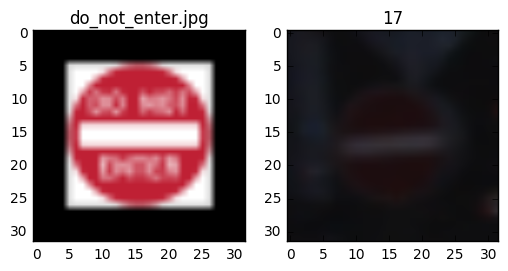

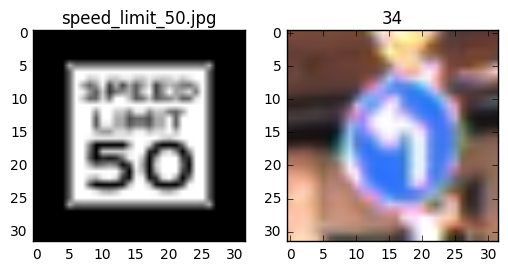

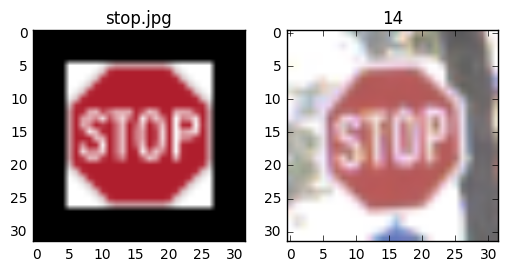

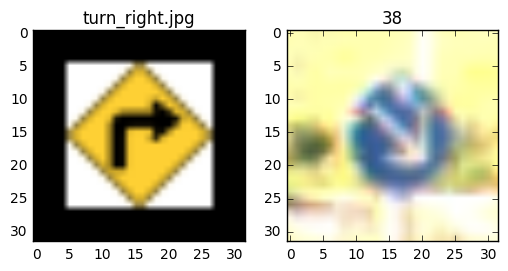

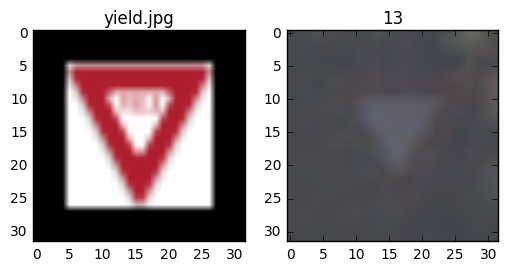

In [17]:
# display the result

for index, name in enumerate(img_names):
    extra_imgs[index] = img_import4(img_folder + name)
    fig = plt.figure()
    a=fig.add_subplot(1,2,1)
    a.set_title(name)
    #plt.title(name)
    plt.imshow(extra_imgs[index])
    
    # display an image from the training set that matches
    img_val = soln_vals[index]
    #extra_labels.append(img_val)
    training_index = next(index for index, val in enumerate(y_train) if val==img_val)
    a=fig.add_subplot(1,2,2)
    a.set_title(str(img_val))
    plt.imshow(X_train[training_index])


### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**
I performed pretty well. What we see is the overall shape of the size is a bigger deteminate for the network than the detains inside the sign.
* For the US signs that match the shapes of the German signs (Do Not Enter, Stop, Yeild), we got good matches
* For the US signs where we needed to match features inside the signs (Speed Limit 50, Turn Right), we didn't get a match

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

[[17 14 33 26 13]
 [34 38 36 20  3]
 [14 33 17 15 38]
 [38 26 18 40 20]
 [13 30 34 23 28]]


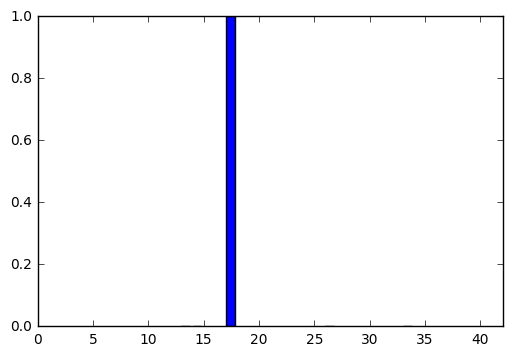

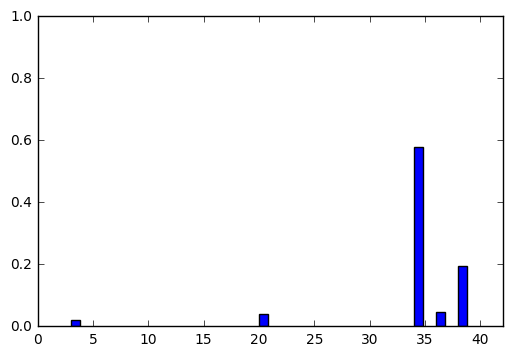

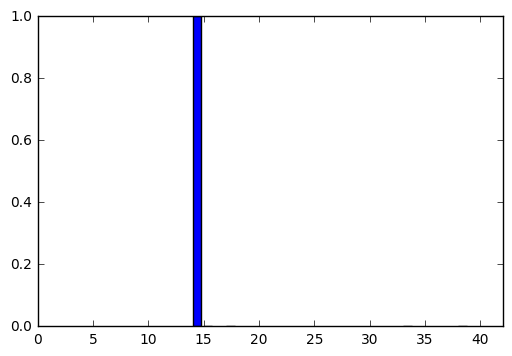

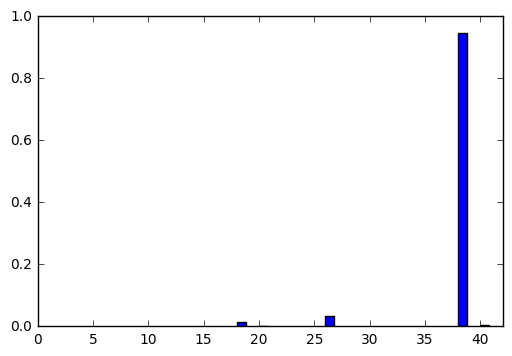

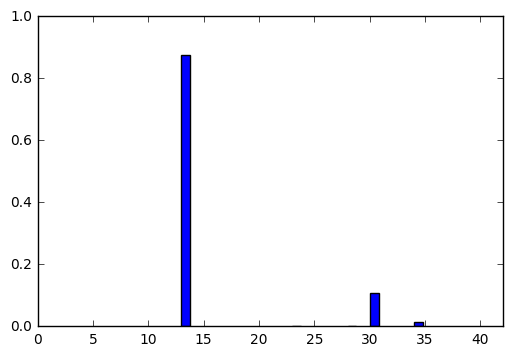

In [52]:
topFive_values = soln_topFive.values
topFive_indices = soln_topFive.indices

print(topFive_indices)

for index, vals_array in enumerate(topFive_values):
    y = vals_array
    x = topFive_indices[index][:]
    fig = plt.figure()    
    plt.bar(x, y, color="blue")
    plt.axis([0, 42, 0, 1])
    #fig.set_title(name)


### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

The model is very certain for:
* Do Not Enter
* Stop
* Turn Right
* Yield

The model is uncertain for:
* Speed Limit 50

The model is incorrect for:
* Speed Limit 50 (correct answer = 2 )
* Turn Right     (correct answer = 33)

For Speed Limit 50, 2="Speed limit (50km/h)" doesn't not show up, but 3="Speed limit (60km/h)" does.
For Turn Right, 33="Turn right ahead" doesn't show up, but 38="Keep right" and 20="Dangerous curve to the right" do show up.

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

I do the following:
* I use matplotlib.image to import the images
* I use opencv to resize the images to 22x22
* I use opencv to add a 5 pixel black border on all sides to make the images 32x32
* I then put the images in a numpy ndarray
* I grayscale the images
* I normalize the images with values between 0.1-0.9

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.